# **Milestone 1 (Continued) - Data Precprocessing**

## Importing Libraries and Modules

The cell below contains all imported libraries that are used in this notebook.

In [ ]:
! pip uninstall -y transformers
! pip install transformers==4.28.0
! pip install datasets
! pip install bert_score rouge_score jiwer evaluate

import evaluate
import pandas as pd
import tqdm
import torch
import math
import transformers
from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset, load_metric
from ast import literal_eval
from statistics import mean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 111.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.7 MB/s eta 0:00:

## Loading data set

Filtered data set was saved in Google Drive in a CSV format and is loaded as Pandas DataFrame as shown below:

In [ ]:
filtered_file_path = '/content/drive/MyDrive/recipe_data/filtered_ingdt_dataset.csv'
filtered_df=pd.read_csv(filtered_file_path)
filtered_df

,NER
0,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
...,...
1634323,"[""salmon"", ""cheese"", ""flour tortilla"", ""green ..."
1634324,"[""bread"", ""Italian sauce"", ""frozen meatballs""]"
1634325,"[""chocolate hazelnut spread"", ""tortillas"", ""bu..."
1634326,"[""eggs"", ""paprika"", ""salt"", ""choice"", ""miracle..."


## Preprocess data set

The precprocessing of the data consists of two tasks that need to be completed:
1.   Insertion of control tokens into segmented data set (training, validation and test with 60:20:20 split)
2.   Tokenize all data



### 1. Insert control tokens + Segment data set

Initially, a **for loop** implementation was considered and implemented. However, it too inefficient considering the quantity of data, which resulted in an exorbitant processing time. Various methods were researched, with the quantity of data proving to be the primary obstacle for the insertion of tokens.

**Vectorization** was also considered to accelerate process. Although vectorization effectively parallelises the processing of all data in the dataframe, its application within the Colab environment with limited RAM was infeasible. This is because vectorization is too memory itesive, applying the function to a vector containing all the input data at once, and any intermediate values are also stored in vectors, thus crashing the Colab session as all available RAM was used up.

Sources:

https://stackoverflow.com/questions/7078371/how-to-avoid-enormous-additional-memory-consumption-when-using-numpy-vectorize

https://www.exxactcorp.com/blog/Deep-Learning/how-to-speed-up-python-pandas-by-over-300x



Finally settled on using the **`apply()`** function istead. Whilst it does process the data sequentially as well, looping over a specified axis of the dataframe, it is able to compile faster by utilising Cython, C-extensions for Python. C, a compiled language, is faster than Python, an interpreted language, as a C program is converted into assembly language and then machine code, which can be directly executed by the CPU. Overall, the **`apply()`** function strikes the appropriate middle ground between memory usage and efficiency.

Sources:

https://medium.com/analytics-vidhya/hey-pandas-why-you-no-fast-loop-e7226ed97322

https://www.freecodecamp.org/news/compiled-versus-interpreted-languages/


In [ ]:
def insert_tokens(start_token, mid_token, end_token, filtered_df_column):
    """Inserts 3 types of control tokens into columns"""
    # literal_eval is able to determine the data structure from the string and convert it into a list of strings
    input_with_tokens = filtered_df_column.apply(literal_eval)
    input_with_tokens = input_with_tokens.apply(lambda x : start_token + str.join(mid_token, x) + end_token)
    return input_with_tokens

In [ ]:
def df_to_dataset(dataset):
    """Convert df into list of dicts then HuggingFace Dataset"""
    list_dataset = []

    for ingredient in tqdm.tqdm(dataset):
        example = {
            "ingredients": ingredient
        }

        list_dataset.append(example)

    return  Dataset.from_list(list_dataset)

In [ ]:
ingredients_count = len(filtered_df)
training_ingredients_count = math.ceil(0.6 * ingredients_count)
validation_ingredients_count = math.ceil((ingredients_count - training_ingredients_count) / 2)
test_ingredients_count = ingredients_count - training_ingredients_count - validation_ingredients_count

In [ ]:
train_ingredients_dataset = insert_tokens("<NER_START> ", " <NEXT_NER> ", " <NER_END>", filtered_df["NER"][:training_ingredients_count])
val_ingredients_dataset = insert_tokens("<NER_START> ", " <NEXT_NER> ", " <NER_END>", filtered_df["NER"][training_ingredients_count:training_ingredients_count+validation_ingredients_count])
test_ingredients_dataset = insert_tokens("<NER_START> ", " <NEXT_NER> ", " <NER_END>", filtered_df["NER"][training_ingredients_count+validation_ingredients_count:ingredients_count])

In [ ]:
train_ingredients_dataset = df_to_dataset(train_ingredients_dataset)
val_ingredients_dataset = df_to_dataset(val_ingredients_dataset)
test_ingredients_dataset = df_to_dataset(test_ingredients_dataset)

100%|██████████| 326865/326865 [00:00<00:00, 2263396.88it/s]


As shown below, the control tokens have been successfully added to the input:

In [ ]:
train_ingredients_dataset[0]['ingredients']

'<NER_START> brown sugar <NEXT_NER> milk <NEXT_NER> vanilla <NEXT_NER> nuts <NEXT_NER> butter <NEXT_NER> bite size shredded rice biscuits <NER_END>'

In [ ]:
val_ingredients_dataset[0]['ingredients']

'<NER_START> oil <NEXT_NER> red onion <NEXT_NER> garlic <NEXT_NER> red <NEXT_NER> mushroom <NEXT_NER> fresh spinach leaves <NEXT_NER> salt <NEXT_NER> marjoram <NER_END>'

In [ ]:
test_ingredients_dataset[0]['ingredients']

'<NER_START> cubes <NEXT_NER> vanilla liqueur <NEXT_NER> Hpnotiq <NEXT_NER> Lemon-lime soda <NER_END>'

### 2. Tokenize data

Insert control tokens, split data set into training, validation and test set. Use fast tokenizer to speed up tokenization process.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
tokenizer.add_tokens(["<NER_START>", "<NEXT_NER>", "<NER_END>"])

3

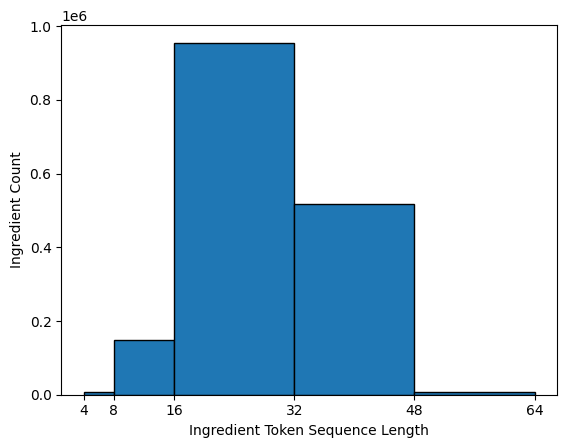

In [ ]:
max_ingredients_length = 48

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def tokenize_function(ingredients):
    "Tokenize, pad, and truncate recipe entry converted to PyTorch tensor"
    model_input = tokenizer(ingredients["ingredients"], max_length=max_ingredients_length, padding="max_length", truncation=True, return_tensors="pt").to(device)

    return model_input

def tokenize_dataset(dataset):
    "Batch tokenizes recipe entries in dataset"
    dataset = dataset.map(tokenize_function, batched=True)

    # remove unnecessary column to reduce memory usage
    dataset = dataset.remove_columns(["ingredients"])

    return dataset

The **`.map`** function allows the dataset to be tokenized in batches, significantly reducing the processing time.

In [ ]:
train_ingredients_dataset = tokenize_dataset(train_ingredients_dataset)
val_ingredients_dataset = tokenize_dataset(val_ingredients_dataset)
test_ingredients_dataset = tokenize_dataset(test_ingredients_dataset)

Map:   0%|          | 0/980597 [00:00<?, ? examples/s]

Map:   0%|          | 0/326866 [00:00<?, ? examples/s]

Map:   0%|          | 0/326865 [00:00<?, ? examples/s]

In [ ]:
train_ingredients_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 980597
})

In [ ]:
val_ingredients_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 326866
})

In [ ]:
test_ingredients_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 326865
})

As shown below, the recipes have been successfully tokenized, padded and truncated:

In [ ]:
tokenizer.decode(train_ingredients_dataset[0]['input_ids'])

'<NER_START> brown sugar <NEXT_NER> milk <NEXT_NER> vanilla <NEXT_NER> nuts <NEXT_NER> butter <NEXT_NER> bite size shredded rice biscuits <NER_END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'

In [ ]:
tokenizer.decode(val_ingredients_dataset[0]['input_ids'])

'<NER_START> oil <NEXT_NER> red onion <NEXT_NER> garlic <NEXT_NER> red <NEXT_NER> mushroom <NEXT_NER> fresh spinach leaves <NEXT_NER> salt <NEXT_NER> marjoram <NER_END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'

In [ ]:
tokenizer.decode(test_ingredients_dataset[0]['input_ids'])

'<NER_START> cubes <NEXT_NER> vanilla liqueur <NEXT_NER> Hpnotiq <NEXT_NER> Lemon-lime soda <NER_END><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>'

# **Milestone 2 & 4 - Formulate and Fine-Tune Base Architecture + Initial Evaluation**

Need to compute metrics and find way to compare training of different models: bertscore, wer, meteor, rouge, bleu

The idea of mixed precision training is that no all variables need to be stored in full (32-bit) floating point precision. If we can reduce the precision the variales and their computations are faster. The main advantage comes from saving the activations in half (16-bit) precision. Although the gradients are also computed in half precision they are converted back to full precision for the optimization step so no memory is saved here. Since the model is present on the GPU in both 16-bit and 32-bit precision this can use more GPU memory (1.5x the original model is on the GPU), especially for small batch sizes. Since some computations are performed in full and some in half precision this approach is also called mixed precision training. Enabling mixed precision training is also just a matter of setting the fp16 flag to True, shaved training time from 27h20min to 11h45min:

Each validation run only takes 28min as only forward pass is needed without any back propagation and adjustment of weights.

Computing the meteor score takes too long (>1 hour) due to the large quantity of data and significant processing that needs to be done per prediction/label. Thus, it is just not beneficial and we substitute its semantic similarity with BERTScore instead (that is also based on cosim).

In [ ]:
# load evaluative metrics to be used on validation set
rouge = evaluate.load("rouge")
meteor = load_metric("meteor")
sbert_cosine = evaluate.load("transZ/sbert_cosine")
wer = evaluate.load("wer")
bleu = evaluate.load("bleu")

<ipython-input-20-eaeac80b5d1b>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  meteor = load_metric("meteor")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Load pre-trained GPTLMHeadModel for specific purpose of casual language modelling
# GPT2-Small used to prevent overfitting and reduce training time (fewer parameters)
# uses cross-entropy loss


model = GPT2LMHeadModel.from_pretrained("gpt2")
# The number of new tokens in the embedding matrix. Increasing the size will add newly initialized vectors at the end. Reducing the size will remove vectors from the end.
model.resize_token_embeddings(len(tokenizer))
# both the model and the data need to be on the GPU to conduct training there
model = model.to(device)

In [ ]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Workaround to avoid storing too many tensors that are not needed.
    """
    # takes the most likely tokens from the output logits to formulate the predictions
    pred_ids = torch.argmax(logits, dim=-1)

    return pred_ids, labels

def compute_metrics(pred):

    labels_ids = pred.label_ids
    pred_ids = pred.predictions[0]

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # ~5min
    rouge_output = rouge.compute(
        predictions=pred_str,
        references=label_str,
        rouge_types=["rouge2"],
        use_aggregator=True,
    )["rouge2"]

    # metrics take into account semantic similarity are siginificantly slower, thus a smaller subset of the validation results are used
    meteor_output = meteor.compute(
        predictions=pred_str[:25000],
        references=label_str[:25000],
    )["meteor"]

    sbert_cosine_output = sbert_cosine.compute(
        predictions=pred_str[:25000],
        references=label_str[:25000],
    )["score"]

    wer_output = wer.compute(
        predictions=pred_str,
        references=label_str,
    )

    label_str = [[label] for label in label_str]

    # This metric takes as input a list of predicted sentences and a list of lists of reference sentences (since each predicted sentence can have multiple references)
    bleu_output = bleu.compute(
        predictions=pred_str,
        references=label_str,
    )["bleu"]

    return {
        "R2": round(rouge_output, 4),
        "METEOR": round(meteor_output, 4),
        "SBert": round(mean(sbert_cosine_output), 4),
        "WER": round(wer_output, 4),
        "BLEU": round(bleu_output, 4),
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/checkpoints",
    save_strategy="epoch",
    logging_dir="/content/drive/MyDrive/runs/full_ingdt_training2",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    load_best_model_at_end=True,
    optim="adamw_torch",
    learning_rate=1e-3,
    weight_decay=0.02,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    fp16=True,
    label_names=["input_ids"]
)

# mlm set to False, as we are conducting casual language modelling, not masked language modelling
# forms batches from the training and validation dataset
# We can use the DataCollatorForLanguageModeling collator, which is designed specifically for language modeling (as the name subtly suggests). Besides stacking and padding batches, it also takes care of creating the language model labels — in causal language modeling the inputs serve as labels too (just shifted by one element), and this data collator creates them on the fly during training so we don’t need to duplicate the input_ids.
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

#Trainer class shuffles the training dataset at every epoch, preventing overfitting
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ingredients_dataset,
    eval_dataset=val_ingredients_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/ML_Chef_models/ingredient_model2")

# to evaluate model change the eval_dataset to test_ingredients_dataset
# and instead of trainer.train() use trainer.evaluate()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,R2,Meteor,Sbert,Wer,Bleu
1,1.353900,1.876087,0.366700,0.533600,0.887300,0.663500,0.520100
2,1.239600,1.825769,0.355900,0.532500,0.869200,0.760400,0.524500


Epoch,Training Loss,Validation Loss,R2,Meteor,Sbert,Wer,Bleu
1,1.353900,1.876087,0.366700,0.533600,0.887300,0.663500,0.520100
2,1.239600,1.825769,0.355900,0.532500,0.869200,0.760400,0.524500
3,1.203900,1.800327,0.322700,0.525300,0.855100,1.097900,0.472000
4,1.173600,1.785572,0.336200,0.533200,0.864300,0.959100,0.495900
5,1.138700,1.779783,0.324700,0.534400,0.855800,1.121100,0.471500
6,1.091800,1.795706,0.356800,0.544600,0.861800,0.820800,0.524100


In [ ]:
generation_kwargs = {
    "max_length": 48,
    "min_length": 9,
    "top_k":  5,
    "temperature": 1,
    "pad_token_id": 50257,
    "do_sample": True, #for top k sampling
}

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

def infer(inp, model):
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    a = inp["attention_mask"].to(device)
    output = model.generate(X, attention_mask=a, **generation_kwargs )
    output = tokenizer.decode(output[0])
    return output

def postprocess_ingredients(ingredients):
    full_ingredients = []
    ingredients_words = ingredients.split()

    for word in ingredients_words:
        if word == "<NER_END>":
            full_ingredients.append(word)
            break
        else:
            full_ingredients.append(word)

    ingredients = full_ingredients[full_ingredients.index("<NER_START>")+1:full_ingredients.index("<NER_END>")]

    ingredient = ""

    print("Ingredients:")

    for word in ingredients:
      if word == "<NEXT_NER>":
          print(f"- {ingredient}")
          ingredient = ""
      else:
          ingredient = ingredient + word + " "

    print(f"- {ingredient}")

def postprocess_input_ingredients(ingredients):
    full_ingredients = []
    ingredients_words = ingredients.split()

    for word in ingredients_words:
        if word == "<NER_END>":
            full_ingredients.append(word)
            break
        else:
            full_ingredients.append(word)

    input_ingredients = " ".join(full_ingredients)

    return input_ingredients


In [ ]:
input1 = "<NER_START> macaroni <NEXT_NER> butter <NEXT_NER> salt <NEXT_NER> bacon <NEXT_NER> milk <NEXT_NER> flour <NEXT_NER> pepper <NEXT_NER>"
input2 = "<NER_START> provolone cheese <NEXT_NER> bacon <NEXT_NER> bread <NEXT_NER>"
input3 = "<NER_START> pork chop <NEXT_NER>"

training_model1 = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/ML_Chef_models/ingredient_model2")
training_model1 = training_model1.to(device)


print(postprocess_input_ingredients(infer(input1, training_model1)))
print(postprocess_input_ingredients(infer(input2, training_model1)))
print(postprocess_input_ingredients(infer(input3, training_model1)))

<NER_START> macaroni <NEXT_NER> butter <NEXT_NER> salt <NEXT_NER> bacon <NEXT_NER> milk <NEXT_NER> flour <NEXT_NER> pepper <NEXT_NER> American cheese <NEXT_NER> bread <NER_END>
<NER_START> provolone cheese <NEXT_NER> bacon <NEXT_NER> bread <NEXT_NER> butter <NEXT_NER> garlic <NER_END>
<NER_START> pork chop <NEXT_NER> cream of chicken soup <NEXT_NER> water <NEXT_NER> onion <NEXT_NER> celery <NEXT_NER> rice <NER_END>
